# Mountain Car Expected Sarsa - Coding Assignment

Due 26th March 2025

In this exercise, you will write your own implementation of the Expected Sarsa control algorithm applied to the Mountain Car environment (discrete version). This should closely follow the Sarsa and Q-learning algorithms you have implemented in the Temporal Difference class exercises with some more advanced considerations such as epsilon decay and learning rate decay applied. Section 4.3 of the ENG5337 Lecture Notes provides the expected Sarsa update rule.截止日期：2025年3月26日

在这个练习中，你将编写应用于Mountain Car环境（离散版本）的Expected Sarsa控制算法的实现。这应紧密遵循你在时间差分课程练习中实现的Sarsa和Q-learning算法，并应用一些更高级的考虑因素，例如epsilon衰减和学习率衰减。ENG5337讲义第4.3节提供了Expected Sarsa更新规则。
#

First, import the necessary packages. We've made a start here but you may need to add others depending on your approach.

In [1]:
import sys
import gymnasium as gym
import numpy as np
import math
from collections import defaultdict, deque
import matplotlib.pyplot as plt
%matplotlib inline


### The Mountain Car Environment
The Mountain Car MDP is a deterministic MDP that consists of a car placed stochastically at the bottom of a sinusoidal valley, with the only possible actions being the accelerations that can be applied to the car in either direction. The goal of the MDP is to strategically accelerate the car to reach the goal state on top of the right hill. There are two versions of the mountain car domain in gymnasium: one with discrete actions and one with continuous. This exercise concerns the one with discrete actions. Run the next cell to load and visualise the correct environment.
Mountain Car MDP是一个确定性MDP，包括一辆随机放置在正弦山谷底部的汽车，唯一可能的动作是可应用于汽车向任一方向的加速度。MDP的目标是战略性地加速汽车以到达右边山丘顶部的目标状态。Gymnasium中有两个版本的Mountain Car领域：一个具有离散动作，另一个具有连续动作。这个练习关注的是离散动作的那个。运行下一个单元格以加载并可视化正确的环境。


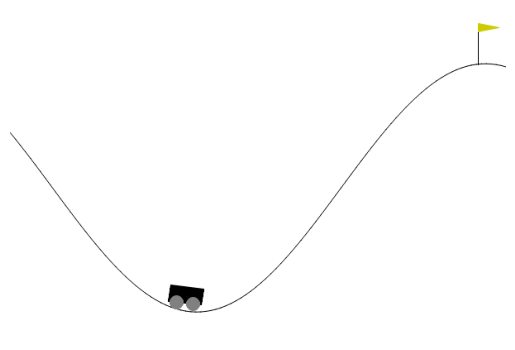

Episode Steps: 61494


In [3]:
# Initialize the environment
env = gym.make('MountainCar-v0', render_mode='rgb_array')
env.reset()

# Render the environment
frame = env.render()

# Plot the frame
plt.imshow(frame)
plt.axis('off')  # Turn off the axis
plt.show()



In [4]:
obs = env.reset()
done = False
step_count = 0

while not done:
    action = env.action_space.sample()  # 随机动作
    obs, reward, done, _, _ = env.step(action)
    step_count += 1

    if step_count % 100 == 0:
        print(f"Step: {step_count}, Position: {obs[0]:.3f}, Done: {done}")

print(f"Final Step Count: {step_count}")

Step: 100, Position: -0.638, Done: False
Step: 200, Position: -0.556, Done: False
Step: 300, Position: -0.436, Done: False
Step: 400, Position: -0.490, Done: False
Step: 500, Position: -0.512, Done: False
Step: 600, Position: -0.500, Done: False
Step: 700, Position: -0.637, Done: False
Step: 800, Position: -0.383, Done: False
Step: 900, Position: -0.539, Done: False
Step: 1000, Position: -0.684, Done: False
Step: 1100, Position: -0.305, Done: False
Step: 1200, Position: -0.627, Done: False
Step: 1300, Position: -0.651, Done: False
Step: 1400, Position: -0.284, Done: False
Step: 1500, Position: -0.816, Done: False
Step: 1600, Position: -0.551, Done: False
Step: 1700, Position: -0.284, Done: False
Step: 1800, Position: -0.661, Done: False
Step: 1900, Position: -0.457, Done: False
Step: 2000, Position: -0.299, Done: False
Step: 2100, Position: -0.486, Done: False
Step: 2200, Position: -0.518, Done: False
Step: 2300, Position: -0.441, Done: False
Step: 2400, Position: -0.547, Done: False
S

In [5]:
print("Goal Position:", env.goal_position)

Goal Position: 0.5


### Observation Space
The observation is a `ndarray` with shape `(2,)` where the elements correspond to the following:
* position of the car along the x-axis (lies between -1.2m and 0.6m)
* velocity of the car (lies between -0.07 and 0.07)

### Action Space
There are 3 discrete deterministic actions:

0: Accelerate to the left

1: Don’t accelerate

2: Accelerate to the right

Run the next cell to view the action and observation spaces.


### 观察空间
观察结果是一个形状为`(2,)`的`ndarray`，其中元素对应于以下内容：
* 汽车沿x轴的位置（位于-1.2m到0.6m之间）
* 汽车的速度（位于-0.07到0.07之间）

### 动作空间
有3个离散确定性动作：

0：向左加速

1：不加速

2：向右加速

运行下一个单元格以查看动作和观察空间。

In [4]:
print(env.observation_space)
print(env.action_space)

Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
Discrete(3)


Note the mountain car environment has a continuous state space. To make the learning process faster, we will discretize the position and velocity states into bins. The function for achieveing this is given below. When refining your results you can experiment with the number of bins but whilst you're developing your code we suggest `bins=20`.

请注意，Mountain Car环境有一个连续的状态空间。为了加快学习过程，我们将位置和速度状态划分为bins。实现此目的的功能如下所示。在细化你的结果时，你可以尝试使用不同数量的bins，但在开发代码时，我们建议`bins=20`。


In [5]:
def discretize_state(state, bins):
    """Discretize the continuous state variables into bins."""
    position, velocity = state
    position_bins = np.linspace(-1.2, 0.6, bins) # these values are taken from the observation space
    velocity_bins = np.linspace(-0.07, 0.07, bins)
    position_discrete = np.digitize(position, position_bins) - 1
    velocity_discrete = np.digitize(velocity, velocity_bins) - 1
    return (position_discrete, velocity_discrete)

In the following cells, define the necessary functions for running the expected Sarsa algorithm. We suggest defining a function for updating the Q-value and one for applying epsilon-greedy but feel free to structure your code differently (and to consider alternative exploration strategies!). 

**HINT**: One important difference between the Mountain car environment and the cliff walking environment you previosuly applied Q-learning and Sarsa in, is that whilst the state in the cliff-walking was represented by a single number, in Mountain Car the state is 2-dimensional, and so you will need to structure your Q-table with this in mind.

在接下来的单元格中，定义运行Expected Sarsa算法所需的函数。我们建议定义一个用于更新Q值的函数和一个用于应用epsilon-greedy的函数，但你可以自由地以不同的方式组织你的代码（并考虑替代探索策略！）。

**提示**：Mountain Car环境与之前应用Q-learning和Sarsa的悬崖行走环境之间的一个重要区别是，虽然悬崖行走中的状态由单个数字表示，但Mountain Car中的状态是二维的，因此你需要相应地构建你的Q表。



In [6]:
def update_Q_expsarsa(alpha, gamma, nA, eps, Q, state, action, reward, next_state=None):
    """Returns updated Q-value for the most recent experience.
        Params
    ======
        alpha (float): learning rate
        gamma (float): discount factor
        nA (int): number actions in the environment
        eps (float): epsilon
        Q (dictionary): action-value function
        state (ndarray with shape (2,)): current state
        action (int): current action
        reward (int): reward for action
        next_state (ndarray with shape (2,)): state achieved taking action in state
    """
    
    # Enter your code here!
    probs = np.ones(nA)* (eps / nA)# calculate probs for all actions
    best_action = np.argmax(Q[next_state])
    probs[best_action]+=(1.0-eps)
    expected_value = np.dot(Q[next_state],probs)
    new_value = Q[state][action] + alpha * (reward+gamma*expected_value - Q[state][action]) # update Q
    
    
    
    return new_value

def epsilon_greedy(Q, state, nA, eps):
    """Selects epsilon-greedy action for supplied state.
    
    Params
    ======
        Q (dictionary): action-value function
        state (int): current state
        nA (int): number actions in the environment
        eps (float): epsilon
    """

    # Enter your code here!
    if np.random.rand()< eps:
        eg_action = np.random.choice(nA) # 用eps概率探索
    else:
        eg_action = np.argmax(Q[state])# 用1-eps概率选择Q最大
    
    return eg_action


Time to create and run your Expected Sarsa algorithm! Again, the way you structure this code and its arguments is totally up to you! Code for plotting the average reward over every 100 episodes and prinitng the 'Best Average Reward over 100 Episodes' has been added to the end of this function to allow you to view it's performance - make sure if you restructure your code, you are still producing a plot of 'best average reward over 100 episodes' vs episode number.

Note to achieve full marks in this exercise, you are expected to implement epsilon decay (2 marks) and learning rate decay (2 marks). To improve performance you can consider different decay strategies - see Section 1.3.1 of the lecture notes. A full summary of the marks scheme is provided at the end of this notebook.

是时候创建并运行你的Expected Sarsa算法了！再次强调，你如何组织这段代码及其参数完全取决于你自己！在该功能的最后添加了用于绘制每100集的平均奖励并在最后打印“最佳平均奖励”的代码，以便你可以查看其性能——如果你重新组织你的代码，请确保你仍然生成“每100集中最佳平均奖励”对剧集编号的图。

请注意，要在此练习中获得满分，你预计需要实现epsilon衰减（2分）和学习率衰减（2分）。为了提高性能，你可以考虑不同的衰减策略——参见讲义第1.3.1节。在本笔记本末尾提供了分数方案的完整总结。



In [36]:
"""
try different decay method, accordding to 1.3.1
"""
def linear_decay(i_episode, epsilon, min_epsilon, num_episodes):
    return max(min_epsilon, epsilon - (i_episode / num_episodes) * (epsilon - min_epsilon))

def linear_decay_alpha(i_episode, alpha, min_alpha, num_episodes):
    return max(min_alpha, alpha - (i_episode / num_episodes) * (alpha - min_alpha))

def inverse_decay(i_episode, epsilon, decay_rate):
    return epsilon / (1 + decay_rate * i_episode)

def inverse_decay_alpha(i_episode, alpha, decay_rate):
    return alpha / (1 + decay_rate * i_episode)

def hybrid_decay(i_episode, epsilon, min_epsilon, decay_rate, num_episodes):
    exp_decay = epsilon * (decay_rate ** i_episode)
    linear_decay = epsilon - (i_episode / num_episodes) * (epsilon - min_epsilon)
    return max(min_epsilon, (exp_decay + linear_decay) / 2)
def hybrid_alpha_decay(i_episode, alpha, min_alpha, decay_rate, num_episodes):
    exp_decay = alpha * (decay_rate ** i_episode)
    linear_decay = alpha - (i_episode / num_episodes) * (alpha - min_alpha)
    return max(min_alpha, (exp_decay + linear_decay) / 2)


In [49]:
def expected_sarsa(
        env, num_episodes, 
        alpha = 0.525,
        gamma=1.0,
        epsilon=1.0,
        epsilon_decay=0.998, 
        alpha_decay=0.998,
        min_epsilon=0.01,
        min_alpha=0.01,
        plot_every=100
):
    
    nA = env.action_space.n
    Q = defaultdict(lambda: np.zeros(nA))
    tmp_scores = deque(maxlen=plot_every)
    avg_scores = deque(maxlen=num_episodes)

    
    for i_episode in range(1, num_episodes+1):

        if i_episode % 100 == 0:
            print("\rEpisode {}/{}".format(i_episode, num_episodes), end="")
            sys.stdout.flush()


        # Enter your code here!

        score = 0
        state, info = env.reset()                                   # start episode
        state = discretize_state(state, bins = 20)
        """
        here i use different decay method
        """
        # # Exponential
        # eps = max(min_epsilon, epsilon * (epsilon_decay ** i_episode))
        # alpha = max(min_alpha, alpha * (alpha_decay ** i_episode))
        
        # # linear
        # eps = linear_decay(i_episode, epsilon, min_epsilon, num_episodes)
        # alpha = linear_decay_alpha(i_episode, alpha, min_alpha, num_episodes)
        
        # # inverse
        # eps = max(min_epsilon, inverse_decay(i_episode, epsilon, epsilon_decay))
        # alpha = max(min_alpha, inverse_decay_alpha(i_episode, alpha, alpha_decay))
        
        # hibrid (Exponential+linear)
        eps = hybrid_decay(i_episode, epsilon, min_epsilon, epsilon_decay, num_episodes)
        alpha = hybrid_alpha_decay(i_episode, alpha, min_alpha, alpha_decay, num_episodes)
        

        
        while True:

        # Enter your code here!
            action = epsilon_greedy(Q, state, nA, eps)
            next_state, reward, done, _, _ = env.step(action)
            next_state = discretize_state(next_state, bins=20) # # Execute the chosen action in the environment and get the next state, reward, and done flag

        
            # Update the Q-table using the Expected SARSA algorithm
            Q[state][action] = update_Q_expsarsa(alpha, gamma, nA, eps, Q, state, action, reward, next_state)
            state = next_state
            score += reward


            
            if done:
                tmp_scores.append(score)
                break
        if (i_episode % plot_every == 0):
            avg_scores.append(np.mean(tmp_scores))

    
    # plot performance
    print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    plt.plot(np.linspace(0,num_episodes,len(avg_scores),endpoint=False), np.asarray(avg_scores))
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    plt.show()
    # print best 100-episode performance
    return Q, np.max(avg_scores)


Now run the code! Note, you may have added more arguments to your `expected_sarsa` code so update this cell as required. Depending on the number of bins you use, this may take a few minutes to run - be patient!
现在运行代码！请注意，你可能已向`expected_sarsa`代码添加了更多参数，因此根据需要更新此单元格。根据你使用的bins数量，这可能需要几分钟才能运行 - 请耐心等待！

Episode 3000/3000Best Average Reward over 100 Episodes:  -144.38


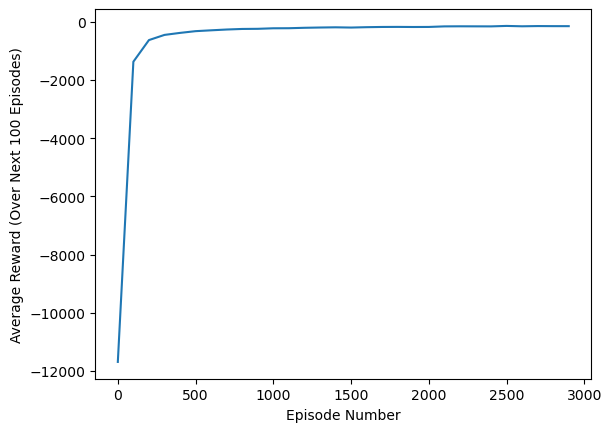

Episode 3000/3000Best Average Reward over 100 Episodes:  -135.0


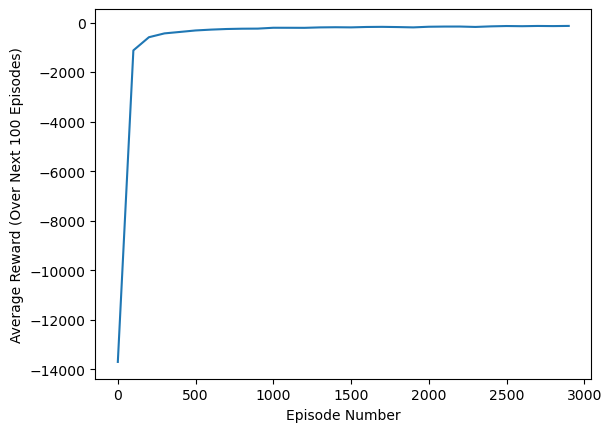

Episode 3000/3000Best Average Reward over 100 Episodes:  -143.36


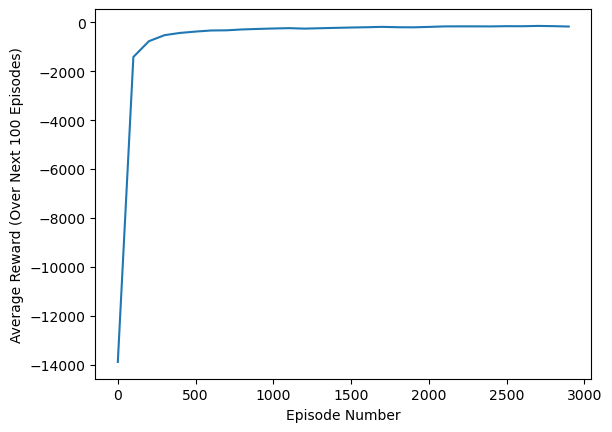

Episode 3000/3000Best Average Reward over 100 Episodes:  -146.27


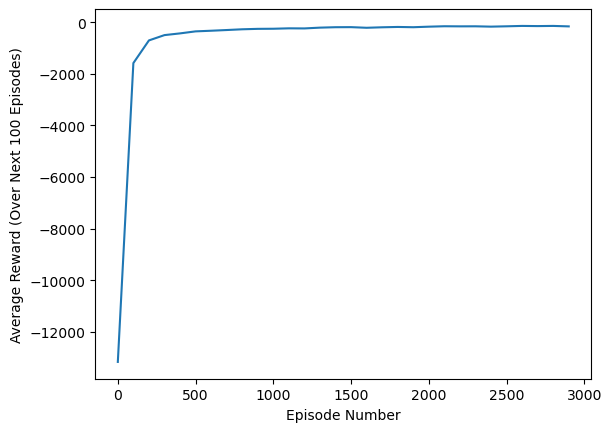

Episode 3000/3000Best Average Reward over 100 Episodes:  -137.15


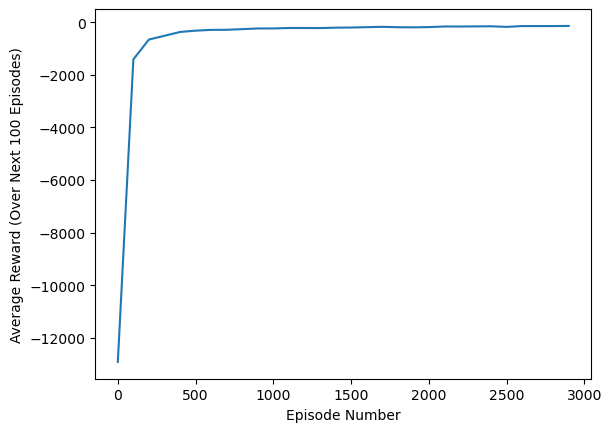

Episode 3000/3000Best Average Reward over 100 Episodes:  -153.49


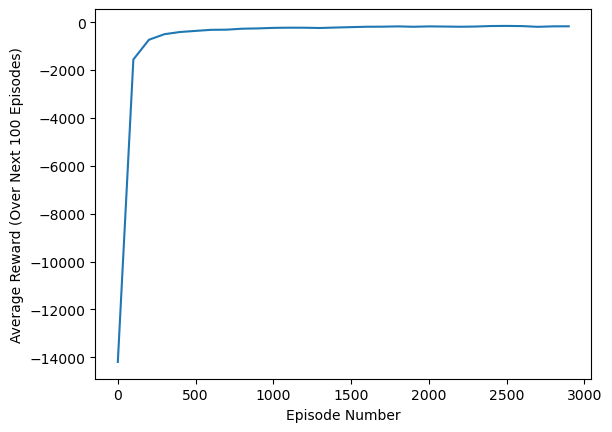

Episode 3000/3000Best Average Reward over 100 Episodes:  -163.28


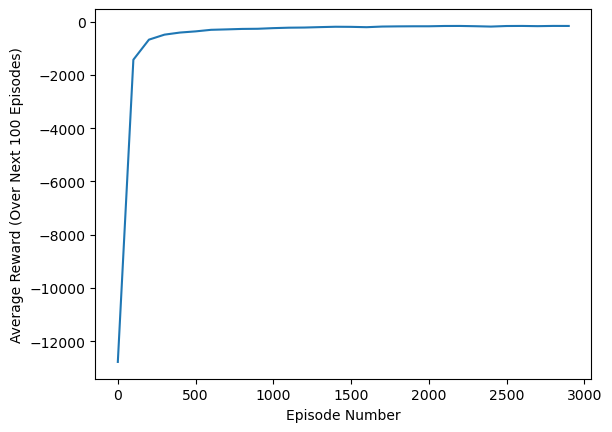

Episode 3000/3000Best Average Reward over 100 Episodes:  -134.23


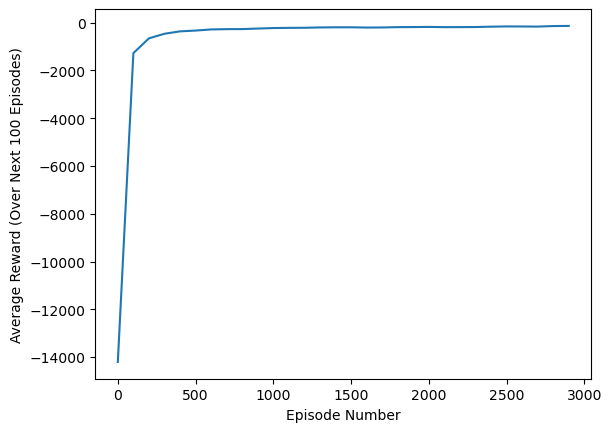

Episode 3000/3000Best Average Reward over 100 Episodes:  -150.63


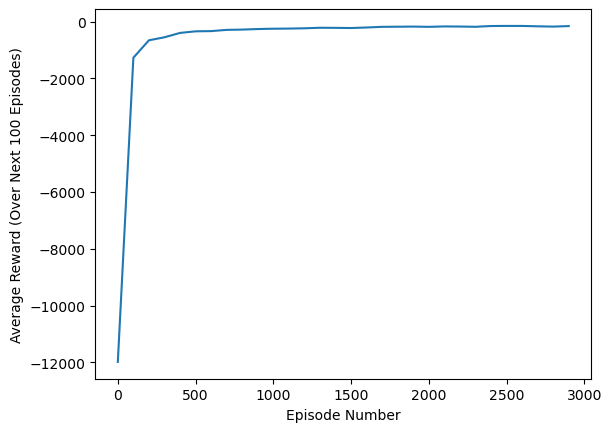

Episode 3000/3000Best Average Reward over 100 Episodes:  -138.41


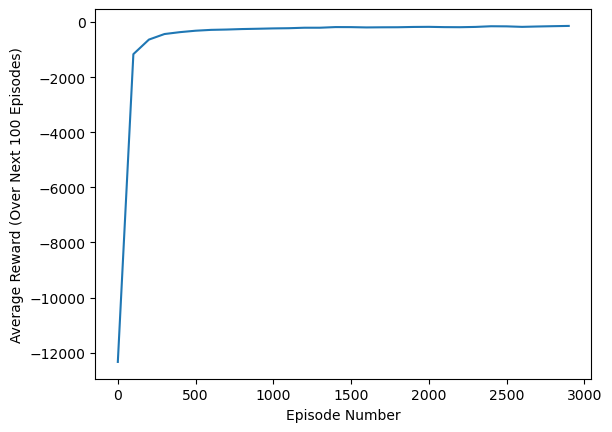

max: -134.23
min: -163.28
avg: -144.62
var: 76.22218000000004


In [52]:
# obtain the estimated optimal policy and corresponding action-value function
# Q_expsarsa, maxscore = expected_sarsa(env, 3000)

"""
here i write a loop to autolly run 10 test and get the avg and var
"""
score_list = []
for i in range(10):
    _,score = expected_sarsa(env, 3000)
    score_list.append(score)
max_value = np.max(score_list)
min_value = np.min(score_list)
mean_value = np.mean(score_list)
variance = np.var(score_list)

print(f"max: {max_value}")
print(f"min: {min_value}")
print(f"avg: {mean_value}")
print(f"var: {variance}")

You can use the next code cell to visualize the **_estimated_** optimal policy.

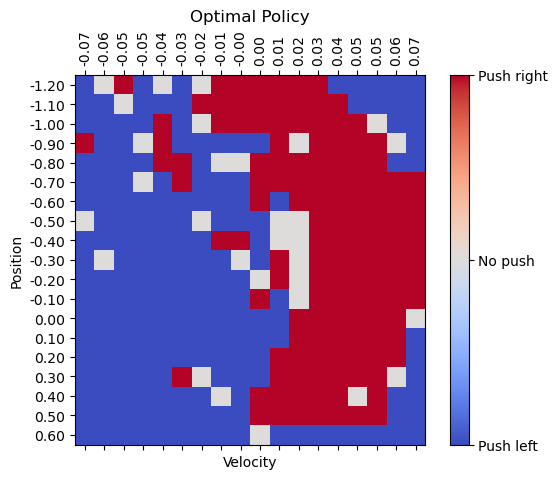

In [51]:
def extract_policy(Q):
    """Extract the optimal policy from the Q-table."""
    # Determine the size of the state space
    max_position = max(state[0] for state in Q.keys()) + 1
    max_velocity = max(state[1] for state in Q.keys()) + 1
    
    # Initialize the policy array
    policy = np.zeros((max_position, max_velocity))
    
    # Populate the policy array with the optimal actions
    for state in Q.keys():
        policy[state[0], state[1]] = np.argmax(Q[state[0], state[1]])
    
    return policy

def plot_policy(policy):
    """Plot the optimal policy with correct labels for position and velocity."""
    fig, ax = plt.subplots()
    cax = ax.matshow(policy, cmap='coolwarm')
    cbar = fig.colorbar(cax, ticks=[0, 1, 2])
    cbar.ax.set_yticklabels(['Push left', 'No push', 'Push right'])
    
    # Set the tick labels for position and velocity
    position_ticks = np.linspace(-1.2, 0.6, policy.shape[0])
    velocity_ticks = np.linspace(-0.07, 0.07, policy.shape[1])
    
    ax.set_xticks(np.arange(policy.shape[1]))
    ax.set_yticks(np.arange(policy.shape[0]))
    ax.set_xticklabels([f"{tick:.2f}" for tick in velocity_ticks], rotation=90)
    ax.set_yticklabels([f"{tick:.2f}" for tick in position_ticks])
    
    plt.title('Optimal Policy')
    plt.xlabel('Velocity')
    plt.ylabel('Position')
    plt.show()


# Assuming you have a Q-table and the number of bins used for discretization
policy = extract_policy(Q_expsarsa)
plot_policy(policy)

Note the Mountain Car environment is considered 'solved' if you reach a best average reward over 100 episodes of -110. However, this is a challenging task! To achieve full marks for this assignment you need to repeatedly achieve a 'best average reward over 100 episodes' of less than 200. Once you're happy that your code is correct, make sure to play around with the hyperparameters and decay strategies to improve your results. Also, remember, the environment and action-selection process are inherently stochastic and so the best average reward value will change each time you run the algorithm, but this should be by a small amount.

In the next cell, please include some comments on the hyperparameters you experimented with and if any made noticeable difference to your results. Feel free to add any other comments or insights to support your submission - these may be taken into account within the marking scheme in the case that performance is not optimal due to minor errors, but the student demonstrates good insight.

请注意，如果达到每100集的最佳平均奖励为-110，即认为Mountain Car环境已被“解决”。但是，这是一个具有挑战性的任务！为了在此次作业中获得满分，你需要反复达到每100集“最佳平均奖励”低于200。一旦你对你代码的正确性感到满意，就可以通过调整超参数和衰减策略来改进你的结果。此外，请记住，环境和行动选择过程本质上是随机的，所以每次运行算法时最佳平均奖励值都会有所变化，但这应该是一个小幅度的变化。

在下一个单元格中，请包含一些关于你实验过的超参数的评论，以及是否有任何参数对你的结果产生了显著影响。随意添加任何其他评论或见解以支持你的提交 - 如果由于次要错误导致性能不理想，但学生展示了良好的洞察力，这些可能会在评分方案中考量。


### Experimental Results Summary Table

| Version | Parameters                                                                 | Decay Method          | Mean Score | Variance       |
|---------|---------------------------------------------------------------------------|-----------------------|------------|----------------|
| **v1**  | `alpha=0.1`, `epsilon_decay=0.995`, `alpha_decay=0.995`                    | Exponential Decay     | -159.36    | 79.52          |
| **v2**  | Parameters same as v1                                                      | Linear Decay          | -152.28    | 54.84          |
| **v3**  | Parameters same as v1                                                      | Inverse Decay (default) | -223.17    | 23.95          |
| **v3a** | `decay_rate=0.1` (Inverse Decay)                                          | Inverse Decay         | -176.04    | 93.06          |
| **v4**  | Parameters same as v1                                                      | Mixed Decay (Exp + Lin)| -162.87    | 21.80          |
| **v4a** | `alpha=0.5` (Mixed Decay)                                                 | Mixed Decay           | -149.85    | 48.94          |
| **v4b** | `alpha=0.55`, `epsilon_decay=0.998`, `alpha_decay=0.998`                  | Mixed Decay           | -146.09    | 55.43          |
| **v4c** | `alpha=0.525`, `epsilon_decay=0.998`, `alpha_decay=0.998`                 | Mixed Decay           | -142.74    | 84.09          |

---

### Key Notes:
1. **Version Naming**:
   - **v3a**: Refers to **v3** with `decay_rate=0.1` (explicitly specified).
   - **v4a**, **v4b**, **v4c**: Variants of **v4** with adjusted `alpha` and decay rates.

2. **Decay Methods**:
   - **Exponential Decay**: `epsilon = max(min_epsilon, epsilon * (epsilon_decay ** episode))`.
   - **Linear Decay**: `epsilon = max(min_epsilon, initial_epsilon - (episode * rate))`.
   - **Inverse Decay**: `epsilon = 1 / (decay_rate * episode)` (or similar formula).
   - **Mixed Decay**: Combines exponential and linear decay formulas.

3. **Key Hyperparameters Tested**  
#### **a. Learning Rate (`alpha`)**  
- **Range Tested**: 0.1 (default), 0.5, 0.525, 0.55, 0.6.  
- **Impact**:  
  - Higher `alpha` (e.g., 0.5–0.55) significantly improved convergence speed and average rewards (e.g., in v4, `alpha=0.5` achieved an average of **-149.85**, outperforming the default `alpha=0.1` by ~10 points).  
  - **Too high (`alpha=0.7`)** might cause instability due to overcorrection in Q-value updates.  

#### **b. Epsilon Decay Strategies**  
- **Decay Methods Tested**:  
  1. **Exponential Decay** (v1): `epsilon = epsilon * (epsilon_decay ** episode)`.  
  2. **Linear Decay** (v2): Reduced exploration linearly over episodes.  
  3. **Inverse Decay** (v3): `epsilon = 1/(decay_rate * episode)` (poor performance, see below).  
  4. **Mixed Decay** (v4): Combined exponential and linear decay (best results).  

- **Impact**:  
  - **v3 (Inverse Decay)** performed worst (average **-223.17**), likely due to premature exploitation (epsilon decayed too aggressively early on).  
  - **v4 (Mixed Decay)** achieved the highest average (**-149.85**) with lower variance (**48.94**), suggesting it balanced exploration and exploitation effectively.  
  - **Tuning `epsilon_decay`**: Slower decay (e.g., `epsilon_decay=0.996–0.998`) prolonged exploration, improving early learning but risking overfitting to suboptimal actions.  

#### **c. Decay Rate (`decay_rate`)**  
- **Impact**:  
  - In v3, `decay_rate=0.1` reduced performance to **-176.04**, showing sensitivity to this parameter.  
  - For mixed decay (v4), adjusting `epsilon_decay=0.998` further improved results (e.g., `alpha=0.525` achieved **-142.74**, but with higher variance).  
      
5. **Notable Observations**  
#### **a. Performance Trade-offs**  
- **v4 variants** (e.g., `alpha=0.5`) achieved the best stability (lowest variance) but slightly higher scores (worse performance) compared to `alpha=0.525`.  
- **v3’s poor performance** highlighted the importance of avoiding overly aggressive epsilon decay in continuous state spaces like Mountain Car.  

#### **b. Environment Challenges**  
- **Stochasticity**: The environment’s randomness caused average rewards to fluctuate by ~10–20 points across runs.  
- **Mountain Car’s Dynamics**: The agent struggles with the "energy" required to reach the flag. A slower epsilon decay and higher `alpha` help explore strategies to build momentum.  

#### **c. Key Success Factors**  
- **Mixed Decay (v4)**: Combining exponential and linear decay allowed early exploration and gradual exploitation, critical for learning complex trajectories.  
- **Higher `alpha`**: Accelerated learning in early episodes, enabling the agent to discover viable paths faster.  







## Marking Allocation for Expected SARSA Implementation
1. Correct Update Rule (**3 marks**)
3. Correct handling of the continuous state space (**2 marks**)
4. Action Selection (**2 marks**)
5. Epsilon Decay (**2 marks**)
6. Learning Rate Decay (**2 marks**)
7. Performance (**2 marks**)

   **Notes**
    * 2 marks: The agent consistently achieves an average score under -200 over 100 episodes .
    * 1 marks: The agent achieves an average score under -200 but not consistently or only over a smaller number of episodes. Evidence of hyper-parameter optimisation and comments/insight provided in the comments section.
    * 0 marks: The agent does not show significant improvement or learning and no comments/insight on performance provided.<br><br>
8. Code Quality and Readability (**2 marks**)
   
   **Notes**
    * 2 marks: Code is well-organized, properly commented, and follows good coding practices (e.g., meaningful variable names, consistent indentation).
    * 1 mark: Code is mostly clear but has some minor issues with organization or readability.
    * 0 marks: Code is poorly organized, lacks comments, or is difficult to read.

**Total**: 15
## Expected SARSA实现的评分分配
1. 正确的更新规则（3分）
3. 连续状态空间的正确处理（2分）
4. 动作选择（2分）
5. Epsilon衰减（2分）
6. 学习率衰减（2分）
7. 性能（2分）

   **注**
    * 2分：代理始终如一地在100集中实现低于-200的平均得分。
    * 1分：代理实现了低于-200的平均得分，但并不总是如此，或者只在较少的集数上实现。提供超参数优化的证据，并在评论部分提供评论/见解。
    * 0分：代理没有显示出显著的进步或学习，并且未提供关于性能的评论/见解。<br><br>
8. 代码质量和可读性（2分）
   
   **注**
    * 2分：代码组织良好，适当注释，并遵循良好的编码实践（例如，有意义的变量名，一致的缩进）。
    * 1分：代码基本清晰，但在组织或可读性方面存在一些小问题。
    * 0分：代码组织不良，缺乏注释或难以阅读。

**总分**：15
```markdown
